<a href="https://colab.research.google.com/github/macsakini/AI-Modelling-/blob/main/agent_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
data = pd.read_excel("general.xlsx", sheet_name="general")

In [ ]:
data.shape

(5005, 11)

In [ ]:
data.head()

,Player ID,Leader,Is_Spy,Total_Spies,Vote,Betray,Mission_size,Mission_Success,Total_Betrayals,Missions_failed,Rounds_complete
0,0,0,True,3,True,True,2,False,1,1,1
1,1,0,False,0,False,None,2,False,1,1,1
2,2,0,False,0,False,None,2,False,1,1,1
3,3,0,True,3,False,True,2,False,1,1,1
4,4,0,False,0,False,None,2,False,1,1,1


In [ ]:
dataset = data.copy()
dataset.tail()

,Player ID,Leader,Is_Spy,Total_Spies,Vote,Betray,Mission_size,Mission_Success,Total_Betrayals,Missions_failed,Rounds_complete
5000,2,5,False,0,True,None,5,True,0,1,5
5001,3,5,False,0,True,None,5,True,0,1,5
5002,4,5,True,3,False,False,5,True,0,1,5
5003,5,5,False,0,True,None,5,True,0,1,5
5004,6,5,True,3,True,False,5,True,0,1,5


In [ ]:
dataset = pd.get_dummies(dataset, columns=['Player ID','Leader','Betray'], 
                         prefix=['Player_ID','Leader','Betray'],
                         prefix_sep = "_" )
dataset.tail()

,Is_Spy,Total_Spies,Vote,Mission_size,Mission_Success,Total_Betrayals,Missions_failed,Rounds_complete,Player_ID_0,Player_ID_1,Player_ID_2,Player_ID_3,Player_ID_4,Player_ID_5,Player_ID_6,Leader_0,Leader_1,Leader_2,Leader_3,Leader_4,Leader_5,Leader_6,Betray_False,Betray_True,Betray_None
5000,False,0,True,5,True,0,1,5,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5001,False,0,True,5,True,0,1,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
5002,True,3,False,5,True,0,1,5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
5003,False,0,True,5,True,0,1,5,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
5004,True,3,True,5,True,0,1,5,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0


In [ ]:
data["Vote"].astype(int)
data["Is_Spy"].astype(int)
data["Mission_Success"].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
5000    1
5001    1
5002    1
5003    1
5004    1
Name: Mission_Success, Length: 5005, dtype: int64

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0).astype(int)
test_dataset = dataset.drop(train_dataset.index).astype(int)

In [ ]:
train_dataset.describe()

,Is_Spy,Total_Spies,Vote,Mission_size,Mission_Success,Total_Betrayals,Missions_failed,Rounds_complete,Player_ID_0,Player_ID_1,Player_ID_2,Player_ID_3,Player_ID_4,Player_ID_5,Player_ID_6,Leader_0,Leader_1,Leader_2,Leader_3,Leader_4,Leader_5,Leader_6,Betray_False,Betray_True,Betray_None
count,4004.000000,4004.000000,4004.000000,4004.00000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,0.428072,1.284216,0.402847,3.27048,0.682817,0.441059,1.184815,3.013736,0.138112,0.145105,0.152098,0.143856,0.142857,0.139860,0.138112,0.196553,0.167083,0.143357,0.167582,0.149101,0.083666,0.092657,0.298951,0.129121,0.571928
std,0.494861,1.484583,0.490532,1.01894,0.465437,0.586953,1.062526,1.424794,0.345060,0.352251,0.359161,0.350988,0.349971,0.346885,0.345060,0.397441,0.373096,0.350480,0.373542,0.356232,0.276921,0.289988,0.457856,0.335376,0.494861
min,0.000000,0.000000,0.000000,2.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.00000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,3.00000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,4.00000,1.000000,1.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,5.00000,1.000000,2.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Vote')
test_labels= test_features.pop('Vote')


In [ ]:
print(train_features)

      Is_Spy  Total_Spies  Mission_size  ...  Betray_False  Betray_True  Betray_None
1261       1            3             2  ...             0            1            0
939        1            3             5  ...             1            0            0
575        1            3             3  ...             1            0            0
666        0            0             2  ...             0            0            1
4294       1            3             4  ...             1            0            0
...      ...          ...           ...  ...           ...          ...          ...
258        1            3             2  ...             1            0            0
3835       1            3             3  ...             1            0            0
769        1            3             5  ...             1            0            0
2061       0            0             5  ...             0            0            1
4215       0            0             3  ...             0       

In [ ]:
from tensorflow.keras.layers import Normalization


normalizer = Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

[[0.4280718  1.2842156  3.2704797  0.6828173  0.44105887 1.1848149
  3.0137355  0.13811192 0.14510486 0.1520979  0.1438561  0.14285715
  0.13986015 0.13811186 0.19655345 0.16708294 0.14335665 0.16758244
  0.14910084 0.08366637 0.09265734 0.298951   0.12912089 0.5719283 ]]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[1 3 2 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]]

Normalized: [[ 1.16  1.16 -1.25  0.68 -0.75 -1.12 -1.41 -0.4   2.43 -0.42 -0.41 -0.41
  -0.4  -0.4   2.02 -0.45 -0.41 -0.45 -0.42 -0.3  -0.32 -0.65  2.6  -1.16]]


In [191]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      #layers.Input(24,),
      norm,
      layers.Dense(64, activation='relu'),
      #layers.Dense(64, activation='sigmoid'),
      layers.Dense(1)
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["accuracy"])
  return model

In [192]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 24)                49        
_________________________________________________________________
dense_54 (Dense)             (None, 64)                1600      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 1,714
Trainable params: 1,665
Non-trainable params: 49
_________________________________________________________________


In [193]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

history

Epoch 1/100
101/101 [==============================] - 1s 4ms/step - loss: 2.6527 - accuracy: 0.5467 - val_loss: 2.1920 - val_accuracy: 0.5431
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 1.6816 - accuracy: 0.5273 - val_loss: 1.2152 - val_accuracy: 0.5194
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 1.0294 - accuracy: 0.5376 - val_loss: 0.9489 - val_accuracy: 0.5194
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 0.9476 - accuracy: 0.5214 - val_loss: 0.8272 - val_accuracy: 0.5268
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 0.7878 - accuracy: 0.5361 - val_loss: 0.7553 - val_accuracy: 0.5106
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 0.7431 - accuracy: 0.5507 - val_loss: 0.7487 - val_accuracy: 0.5231
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 0.7273 - accuracy: 0.5514 - val_loss: 0.7279 - val_accuracy: 0.5218

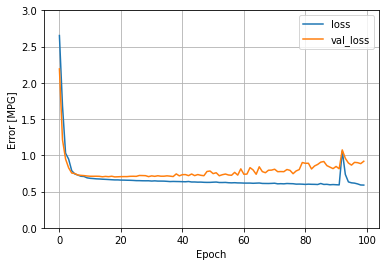

In [194]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [195]:
results = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [196]:
print(f'This is the model loss: {results[0]}')

This is the model loss: 0.8160363435745239


In [198]:
print(f'This is the model accuracy: {results[1]}')

This is the model accuracy: 0.5794205665588379


In [199]:
test_predictions = dnn_model.predict(test_features).flatten()
print(test_predictions)

[0.038 0.614 0.368 ... 0.278 0.514 0.28 ]


In [200]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [201]:
reloaded = tf.keras.models.load_model('dnn_model')

predicted = reloaded.predict(train_features[:100])

a = pd.DataFrame(predicted,train_labels[:100])

In [202]:
a

,0
Vote,
0,0.149074
0,0.234589
0,0.138975
0,0.380321
0,0.379048
...,...
0,0.296207
0,0.097643
1,0.706188
